In [2]:
%pylab inline
import tensorflow as tf
from itertools import groupby
import pandas as pd
from collections import OrderedDict
from datetime import date
import pyodbc

Populating the interactive namespace from numpy and matplotlib


C:\Users\Vivi\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data Preprocessing (can be skipped after done once)

In [ ]:
records=pd.read_csv('C:/Users/Vivi/Desktop/hack4health_RKI-data-scripts/survstat/csv/cam_5y.csv',encoding='latin-1')
CoNew = pd.read_csv('C:/Users/Vivi/Desktop/hack4health_RKI-data-scripts/DieInfluenza/CoordBins.csv',encoding='latin-1')

In [ ]:
recordsX=records[['county','week','count','incidence']]
gb = recordsX.groupby(['week','county']).sum()

In [ ]:
gb.index[0]

In [ ]:
newDF = pd.DataFrame(columns=['week','year','county','count','incidence','X','Y','BinX','BinY','LocCounty'])
x = 0
for i in gb.index:
    week = i[0]
    counties = i[1]
    counts = gb.values[x][0]
    incidences = gb.values[x][1]
    loc = CoNew[CoNew['county']==counties]
    if loc['X'].values>0:
        newDF=newDF.append({'week': str(week)[7:],'year':str(week)[:4],'county':str(counties),'count':str(counts),'incidence':str(incidences),'X':loc['X'].values,'Y':loc['Y'].values,'BinX':loc['BinX'].values,'BinY':loc['BinY'].values,'LocCounty':loc['county'].values}, ignore_index=True)    
    try:
        with open('StomachVirusInput.csv', 'a') as f:
            newDF.to_csv(f, header=False)
    except:
        pass
    newDF=pd.DataFrame(columns=['week','year','county','count','incidence','X','Y','BinX','BinY','LocCounty'])
    x = x+1
#newDF.to_csv('StomachVirusInput.csv')

In [ ]:
newDF = pd.read_csv('StomachVirusInput.csv',encoding='latin-1')
newDF.columns = ['ID','week','year','county','count','incidence','X','Y','BinX','BinY','LocCounty']#.set_index('Unnamed: 0')
newDF = newDF.dropna()
newDF = newDF[['week','year','county','count','incidence','X','Y','BinX','BinY']].reset_index(drop=True)
newDF.to_csv('StomachVirusNew.csv')

In [ ]:
newDF = pd.read_csv('StomachVirusInput.csv',encoding='latin-1')
newDF

In [ ]:
test = newDF[newDF['year']==2001][newDF[newDF['year']==2001]['week']==2]['incidence']

In [ ]:
def FindLabels(data):
    LabelDF = pd.DataFrame(columns=['count','incidence','county'])
    for w in data.index:
        try:
            thisyear = data.iloc[w]['year']
            thisweek = data.iloc[w]['week']
            thisarea = data.iloc[w]['county']
            if int(thisweek)<52:
                nextweek = int(thisweek)+1
                nextyear = int(thisyear)
            else:
                nextweek = 1
                nextyear = int(thisyear)+1
            nextdf = data[data['year']==nextyear][data[data['year']==nextyear]['week']==nextweek]
            nextcount = np.sum(nextdf[nextdf['county']==thisarea]['count'])
            if nextcount>0:
                nextincidence = np.sum(nextdf[nextdf['county']==thisarea]['incidence'])
                nextcounty = nextdf[nextdf['county']==thisarea]['county'].values[0]
            else:
                nextincidence=0  
                nextcounty = 'no Data'
        except:
            nextcount=0
            nextincidence=0  
            nextcounty = 'no Data'
        LabelDF=LabelDF.append({'count':nextcount,'incidence':nextincidence,'county':nextcounty}, ignore_index=True)
        if (w % 1000 == 0):
            print(w)
    return LabelDF
        
label = FindLabels(newDF)
label.to_csv('StomachOutput.csv')

# Load Processed Data

In [3]:
Labels=pd.read_csv('StomachOutput.csv',encoding='latin-1').set_index('Unnamed: 0')
Data=pd.read_csv('StomachVirusInput.csv',encoding='latin-1').set_index('Unnamed: 0')
Data = Data[['week','year','count','incidence','X','Y','county','BinX','BinY']]
dfboth = Data.join(Labels,lsuffix='x',how='outer').dropna()
Data = dfboth[['week','year','countx','incidencex','X','Y','countyx','BinX','BinY']].rename(index=str, columns={"countx": "count", "incidencex": "incidence"})
Labels = dfboth[['count','incidence']]

In [4]:
allMaps = []
for m in range(15):
    for n in range(52):
        year = 2001+m
        thisweek = Data[Data['year']==year][Data[Data['year']==year]['week']==n]
        thisweek = thisweek.reset_index(drop=True)
        currentMap = np.zeros((16,16))
        currentCount = np.zeros((16,16))
        for i in range(shape(thisweek)[0]):
            inc = thisweek['incidence'][i]
            x = int(thisweek['BinX'][i][1:-1])
            y = int(thisweek['BinY'][i][1:-1])
            currentMap[x][y]=currentMap[x][y]+inc
            currentCount[x][y]=currentCount[x][y]+1
        currentMap = currentMap/currentCount
        allMaps.append(np.nan_to_num(currentMap))

C:\Users\Vivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


## Normalize Data

In [ ]:
import sklearn
from sklearn.preprocessing import normalize
normalized = newDF
"""x = normalized['BinX']
normBinX =sklearn.preprocessing.normalize([x],axis=1)
normalized['BinX']=normBinX[0]
x = normalized['BinY']
normBinY =sklearn.preprocessing.normalize([x])
normalized['BinY']=normBinY[0]
x = normalized['X']
normX =sklearn.preprocessing.normalize([x])
normalized['X']=normX[0]
x = normalized['Y']
normY =sklearn.preprocessing.normalize([x])
normalized['Y']=normY[0]"""
x = normalized['count']
normcount =sklearn.preprocessing.normalize([x])
normalized['count']=normcount[0]
x = normalized['incidence']
normInc =sklearn.preprocessing.normalize([x])
normalized['incidence']=normInc[0]

In [ ]:
normLabels = Labels
x = normLabels['count']
normcount =sklearn.preprocessing.normalize([x])
normLabels['count']=normcount[0]
x = normLabels['incidence']
normInc =sklearn.preprocessing.normalize([x])
normLabels['incidence']=normcount[0]

In [5]:
lenall = Data.shape[0]
trainSize = lenall//3*2#define sizes for data sets (train: 2/3, val:1/6, test:1/6 of whole dataset) 
valSize = 0#lenall//6

#Split data into train, val and test set------------------------------------------
trainingData = Data.iloc[0:trainSize].reset_index(drop=True)
trainingLabels = Labels.iloc[0:trainSize].reset_index(drop=True)
validationData = Data.iloc[trainSize+1:trainSize+valSize].reset_index(drop=True)
validationLabels = Labels.iloc[trainSize+1:trainSize+valSize].reset_index(drop=True)
testData = Data.iloc[trainSize+valSize+1:].reset_index(drop=True)
testLabels = Labels.iloc[trainSize+valSize+1:].reset_index(drop=True)

In [6]:
#Method to get batches------------------------------------------------------------
def getBatches(batchsize,typeBatch):
    if typeBatch=="train":
        numBatches = shape(trainingData)[0]//batchsize
        Batches=[]
        for count in range(numBatches-1):
            batch = trainingData[count*batchsize:(count+1)*batchsize]
            labels = trainingLabels[count*batchsize:(count+1)*batchsize]
            b,l=formatBatch(batch,labels,batchsize)
            newb = addGlobalCNN(b,batch.reset_index(),batchsize,batch['week'].reset_index(),batch['year'].reset_index())
            #print(newb)
            Batches.append([newb,l])
    elif typeBatch=="val":
        batch = validationData.sample(batchsize)
        labels = validationLabels.iloc[batch.index]
        b,l=formatBatch(batch,labels,batchsize)
        Batches  = [b,l]
    elif typeBatch=="test":
        batch = testData.sample(batchsize)
        labels = testLabels.iloc[batch.index]
        b,l=formatBatch(batch,labels,batchsize)
        Batches  = [b,l]
    else:
        print("typeBatch needs to be set to one of these values: train, val, test.")
        pass
    return Batches
def getLastWeek(thisweek,thisyear):
    weekdata = Data[Data['year']==thisyear][Data[Data['year']==thisyear]['week']==thisweek]
    #print(weekdata)
    size = shape(weekdata)[0]
    batch = formatBatch(weekdata,weekdata,size)
    return batch,size,weekdata['countyx']

def formatBatch(batch,labels,batchsize):
    batch = batch.reset_index(drop=True)
    labels = labels.reset_index(drop=True)
    newl = []
    newb = []
    for i,b in enumerate(batch['week']):
        x = batch['X'][i][1:-1]
        y = batch['Y'][i][1:-1]
        try:
            newb = np.append(newb,[int(b),int(batch['count'][i])/10,(batch['incidence'][i])/100,float(x)/100,float(y)/100])
        except:
            newb = np.append(newb,[int(b),int(batch['count'][i])/10,(batch['incidence'][i])/100,float(0)/100,float(0)/100])
    for ind,l in enumerate(labels['count']):
        newl = np.append(newl,[l/10,(labels['incidence'][ind])/100],axis=0)
    return np.reshape(newb,(batchsize,5)),np.reshape(newl,(batchsize,2))
def addGlobalCNN(batch,dfBatch,batchsize,week,year):
    records = []
    newb = []
    for i in range(batchsize):
        thisweek = week['week'][i]
        thisyear = year['year'][i]
        MapNum = (thisyear-2001)*52+thisweek
        x = dfBatch['BinX'][i]
        y = dfBatch['BinY'][i]
        binrisk = allMaps[MapNum][int(x[1:-1])][int(y[1:-1])]
        newb = np.append(batch[i],binrisk/100)
        records.append(newb)
    return records

In [ ]:
b = getBatches(50,'train')
#print(b)
for e in b:
    print("batch")
    print(e[0])
    print("labels")
    print(e[1])

In [107]:
tf.reset_default_graph()
%matplotlib notebook
learning_rate = 0.05
batch_size = 20
training_epochs = 100
display_step = 1
complexInput=False
n_hidden_1 = 250 # 1st layer number of neurons
n_hidden_2 = 250 # 2nd layer number of neurons
n_input = 6 
n_classes = 2 
step = 1

# tf Graph input
X = tf.placeholder("float32", [None,n_input])
Y = tf.placeholder("float32",[None,n_classes])

keep_probability = tf.placeholder("float")

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=1/n_input)),#**(-1/2))),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=1/n_hidden_1)),#**(-1/2))),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=1/n_hidden_2))#**(-1/2)))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'bout': tf.Variable(tf.random_normal([n_classes]))
}

def multilayer_perceptron(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.nn.dropout(tf.nn.tanh(tf.add(tf.matmul(x, weights['h1']), biases['b1'])),keep_probability)
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.nn.dropout(tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])),keep_probability)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['bout']
    return out_layer

outP = multilayer_perceptron(X)

loss_op = tf.reduce_mean(tf.losses.mean_squared_error(Y,outP))
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

#tf.summary.scalar("loss", loss_op)
#tf.summary.scalar("sample output",(outP[0][0])*10)
#tf.summary.scalar("sample target output",(Y[0][1])*100)

#merged_summaries = tf.summary.merge_all()

#train_writer = tf.summary.FileWriter("./summaries/trainFFNAreaRisk", tf.get_default_graph())
#validation_writer = tf.summary.FileWriter("./summaries/validationFFNAreaRisk")

In [ ]:
with tf.Session() as sess:
    init = tf.initialize_all_variables()
    sess.run(init)
    saver = tf.train.Saver()
    kp=1.0
    samplePred = []
    sample = []
    allLoss = []
    for n in range(training_epochs):
        losses = []
        for b in getBatches(batch_size,"train"):
            _,loss,output = sess.run([train_op,loss_op,outP], feed_dict={X: b[0],Y: b[1],keep_probability:kp})  

            losses = np.append(losses,lossO)
            step = step + 1
        print(shape(l))
        print(np.where(l>0.2))
            #train_writer.add_summary(_summaries, step)
            #if (step%1000==0):
             #   saver.save(sess,"./log/FFNCountyRisk.ckpt")
        #b = getBatches(batch_size,'val')
        #_,Valloss,output,_Valsummaries = sess.run([train_op,loss_op,outP,merged_summaries], feed_dict={X: np.reshape(b[0],(batch_size,5)),Y: np.reshape(b[1],(batch_size,2)),keep_probability:kp})  
        #print("validation Loss: ",Valloss)
        #validation_writer.add_summary(_Valsummaries, step)
        #print(output)
        lastout = output[3]
        samplePred = np.append(samplePred,output)#lastout[1])
        sample = np.append(sample,b[1])
        allLoss = np.append(allLoss,np.mean(losses))
        print("epoch: ",n,' - Step: ',step)
        print("pred: ",lastout)
        print("true: ",b[1][2])
        print("loss: ",np.mean(losses))
        #print(losses[0])

()
(array([], dtype=int64),)
epoch:  0  - Step:  8795
pred:  [0.32351217 0.75440836]
true:  [0.2        0.70842666]
loss:  0.10931906849145889
()
(array([], dtype=int64),)
epoch:  1  - Step:  17589
pred:  [0.3288718 0.7653053]
true:  [0.2        0.70842666]
loss:  0.10931906849145889
()
(array([], dtype=int64),)
epoch:  2  - Step:  26383
pred:  [0.33262128 0.7696885 ]
true:  [0.2        0.70842666]
loss:  0.10931906849145889
()
(array([], dtype=int64),)
epoch:  3  - Step:  35177
pred:  [0.33387947 0.7688304 ]
true:  [0.2        0.70842666]
loss:  0.10931906849145889
()
(array([], dtype=int64),)
epoch:  4  - Step:  43971
pred:  [0.33629566 0.7648343 ]
true:  [0.2        0.70842666]
loss:  0.10931906849145889
()
(array([], dtype=int64),)
epoch:  5  - Step:  52765
pred:  [0.33837956 0.76137483]
true:  [0.2        0.70842666]
loss:  0.10931906849145889
()
(array([], dtype=int64),)
epoch:  6  - Step:  61559
pred:  [0.3407297 0.7578422]
true:  [0.2        0.70842666]
loss:  0.109319068491458

In [95]:
#sp = samplePred
#s = sample
print(shape(s)[0]/40)
batch_size = 20
epochs = int(shape(s)[0]/(batch_size*2))
Counttargets = np.zeros((batch_size,epochs+1))
Inctargets = np.zeros((batch_size,epochs+1))
CountPred = np.zeros((batch_size,epochs+1))
IncPred = np.zeros((batch_size,epochs+1))
for j in range(batch_size):
    CountPred[j][0]=newoutput[j][0]
    IncPred[j][0]=newoutput[j][1]
    Counttargets[j][0]=first[1][j][0]
    Inctargets[j][0]=first[1][j][1]
    for i in range(epochs):
        print("epoch:",str(i)," - sample: ",str(j))
        print("Pred Count: ",sp[(i*batch_size*2)+(j*2)])
        CountPred[j][i+1]=sp[(i*batch_size*2)+(j*2)]
        print("Target Count: ",s[(i*batch_size*2)+(j*2)])
        Counttargets[j][i+1]=s[(i*batch_size*2)+(j*2)]
        print("Pred Inc: ",sp[(i*batch_size*2)+(j*2)+1])
        IncPred[j][i+1]=sp[(i*batch_size*2)+(j*2)+1]
        print("Target Inc: ",s[(i*batch_size*2)+(j*2)+1])
        Inctargets[j][i+1]=s[(i*batch_size*2)+(j*2)+1]

23.0
epoch: 0  - sample:  0
Pred Count:  0.27724987268447876
Target Count:  0.5
Pred Inc:  0.7669916152954102
Target Inc:  1.365826291570381
epoch: 1  - sample:  0
Pred Count:  0.2687119245529175
Target Count:  0.5
Pred Inc:  0.7584760785102844
Target Inc:  1.365826291570381
epoch: 2  - sample:  0
Pred Count:  0.2712146043777466
Target Count:  0.5
Pred Inc:  0.7509468793869019
Target Inc:  1.365826291570381
epoch: 3  - sample:  0
Pred Count:  0.2747635245323181
Target Count:  0.5
Pred Inc:  0.7442610263824463
Target Inc:  1.365826291570381
epoch: 4  - sample:  0
Pred Count:  0.2778107821941376
Target Count:  0.5
Pred Inc:  0.7386451959609985
Target Inc:  1.365826291570381
epoch: 5  - sample:  0
Pred Count:  0.28007352352142334
Target Count:  0.5
Pred Inc:  0.732579231262207
Target Inc:  1.365826291570381
epoch: 6  - sample:  0
Pred Count:  0.2822473645210266
Target Count:  0.5
Pred Inc:  0.7268447875976562
Target Inc:  1.365826291570381
epoch: 7  - sample:  0
Pred Count:  0.28453826904

epoch: 0  - sample:  4
Pred Count:  0.39929091930389404
Target Count:  0.1
Pred Inc:  0.7782647013664246
Target Inc:  0.297756898034804
epoch: 1  - sample:  4
Pred Count:  0.40333956480026245
Target Count:  0.1
Pred Inc:  0.7804257273674011
Target Inc:  0.297756898034804
epoch: 2  - sample:  4
Pred Count:  0.4038023054599762
Target Count:  0.1
Pred Inc:  0.7816245555877686
Target Inc:  0.297756898034804
epoch: 3  - sample:  4
Pred Count:  0.4030158519744873
Target Count:  0.1
Pred Inc:  0.7805898189544678
Target Inc:  0.297756898034804
epoch: 4  - sample:  4
Pred Count:  0.4027661383152008
Target Count:  0.1
Pred Inc:  0.7786701321601868
Target Inc:  0.297756898034804
epoch: 5  - sample:  4
Pred Count:  0.4026639461517334
Target Count:  0.1
Pred Inc:  0.7758769392967224
Target Inc:  0.297756898034804
epoch: 6  - sample:  4
Pred Count:  0.4039139151573181
Target Count:  0.1
Pred Inc:  0.7737463712692261
Target Inc:  0.297756898034804
epoch: 7  - sample:  4
Pred Count:  0.406393229961395

Pred Inc:  0.5363488793373108
Target Inc:  0.0
epoch: 20  - sample:  11
Pred Count:  0.31595513224601746
Target Count:  0.0
Pred Inc:  0.5361257195472717
Target Inc:  0.0
epoch: 21  - sample:  11
Pred Count:  0.31606727838516235
Target Count:  0.0
Pred Inc:  0.5359101295471191
Target Inc:  0.0
epoch: 22  - sample:  11
Pred Count:  0.3159879446029663
Target Count:  0.0
Pred Inc:  0.5356088280677795
Target Inc:  0.0
epoch: 0  - sample:  12
Pred Count:  0.4125635027885437
Target Count:  0.3
Pred Inc:  0.774476170539856
Target Inc:  0.735251449755983
epoch: 1  - sample:  12
Pred Count:  0.4117363691329956
Target Count:  0.3
Pred Inc:  0.7751173377037048
Target Inc:  0.735251449755983
epoch: 2  - sample:  12
Pred Count:  0.4123639762401581
Target Count:  0.3
Pred Inc:  0.7745903730392456
Target Inc:  0.735251449755983
epoch: 3  - sample:  12
Pred Count:  0.4132150411605835
Target Count:  0.3
Pred Inc:  0.7712656259536743
Target Inc:  0.735251449755983
epoch: 4  - sample:  12
Pred Count:  0.

# Visualization of one batch over 23 epochs

[0.89490265 0.76699162 0.75847608 0.75094688 0.74426103 0.7386452
 0.73257923 0.72684479 0.72273141 0.71887398 0.71534741 0.71223605
 0.70949388 0.70705318 0.7047348  0.70233357 0.69992155 0.697209
 0.69418782 0.69122839 0.68830365 0.68540555 0.68257248 0.67985708]


<IPython.core.display.Javascript object>


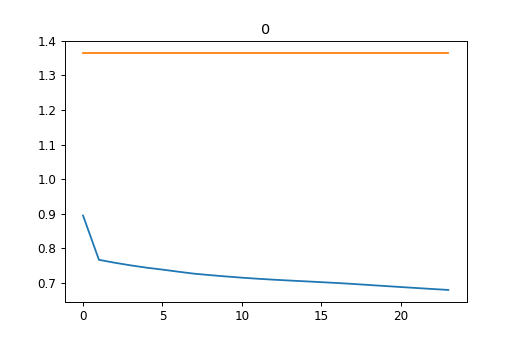

[0.894943   0.66815245 0.66286993 0.65674806 0.65212452 0.64923275
 0.64562666 0.64206713 0.6392107  0.63662446 0.63432616 0.63237524
 0.63072646 0.62934315 0.62817246 0.62721026 0.62555164 0.62494582
 0.62414604 0.62337303 0.62272584 0.62217033 0.62169266 0.62129605]


<IPython.core.display.Javascript object>


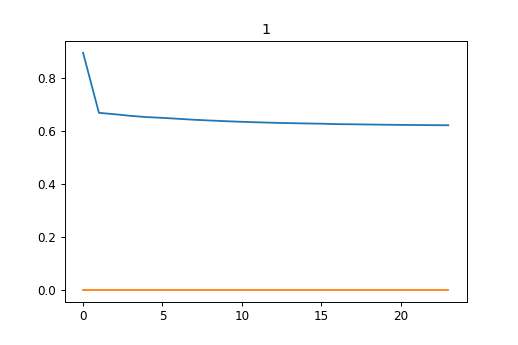

[0.89496499 0.60490757 0.59222513 0.58166862 0.57436633 0.56902188
 0.56457978 0.56301987 0.56091917 0.55885106 0.55677772 0.55488467
 0.55314684 0.55154657 0.5500471  0.54877561 0.5462544  0.54536533
 0.54507208 0.54456878 0.54417771 0.54388642 0.54359782 0.54322881]


<IPython.core.display.Javascript object>


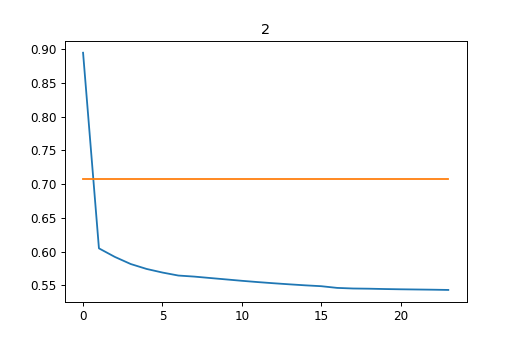

[0.89492202 0.75603324 0.75344664 0.75016785 0.74601018 0.74199647
 0.7369771  0.73235452 0.72862804 0.72525561 0.72223258 0.71957183
 0.71723384 0.71516615 0.71322834 0.71123785 0.70935881 0.70749146
 0.70504826 0.70270407 0.70043749 0.69825482 0.69621122 0.69435775]


<IPython.core.display.Javascript object>


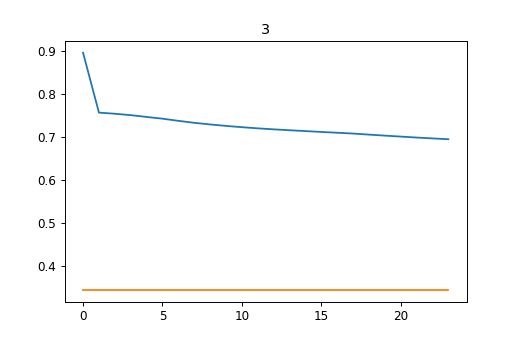

[0.89492899 0.7782647  0.78042573 0.78162456 0.78058982 0.77867013
 0.77587694 0.77374637 0.77138484 0.76919258 0.76725167 0.76551926
 0.76399457 0.76262188 0.76129651 0.7598834  0.75856256 0.75733674
 0.75528938 0.75349468 0.75182104 0.75023782 0.74881184 0.74762702]


<IPython.core.display.Javascript object>


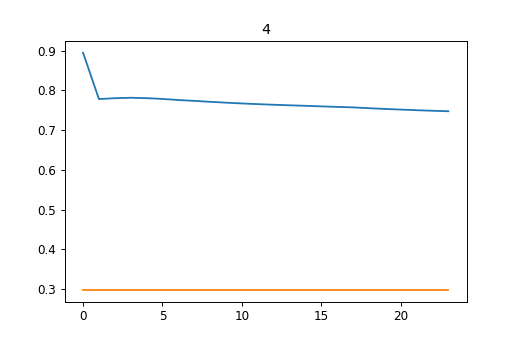

[0.89496779 0.76370752 0.76808888 0.76944745 0.76787281 0.76597512
 0.76546937 0.76698709 0.76780957 0.76837969 0.76893193 0.76925218
 0.76928127 0.768996   0.76841831 0.76751655 0.76569068 0.76449102
 0.76256371 0.76110357 0.75992972 0.75897038 0.75826085 0.75787407]


<IPython.core.display.Javascript object>


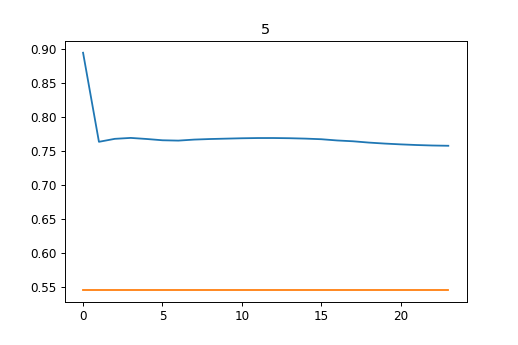

[0.89495897 0.62612289 0.61384952 0.6040175  0.59691179 0.59080476
 0.58672345 0.5870589  0.58655375 0.58609879 0.58553565 0.5848819
 0.5841158  0.58328187 0.58242494 0.58164513 0.57985246 0.57926333
 0.57912135 0.57898009 0.57901233 0.57920897 0.57951462 0.57985979]


<IPython.core.display.Javascript object>


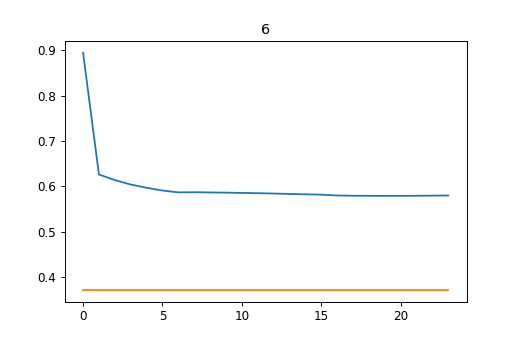

[0.89495462 0.59725076 0.58086336 0.56803119 0.55926347 0.55174822
 0.54652596 0.54675829 0.54589367 0.54504025 0.54400635 0.54291022
 0.54173952 0.54052728 0.53926647 0.53810257 0.53550202 0.53466654
 0.53448725 0.53405696 0.53372639 0.53350747 0.53330672 0.53303242]


<IPython.core.display.Javascript object>


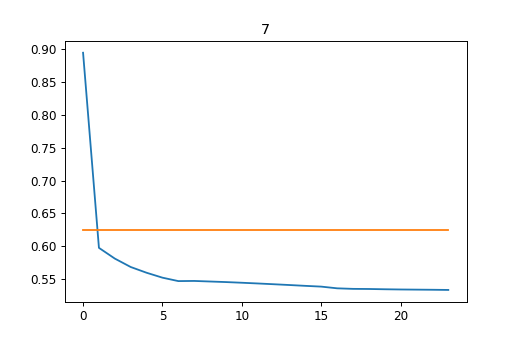

[0.89496177 0.65878135 0.65019405 0.64284146 0.63682836 0.6316449
 0.62827146 0.6287334  0.62862754 0.62863714 0.62861145 0.6284517
 0.62811065 0.62763679 0.62708753 0.62647402 0.62513769 0.62445801
 0.62409592 0.62394643 0.62401569 0.62427258 0.62469447 0.62524533]


<IPython.core.display.Javascript object>


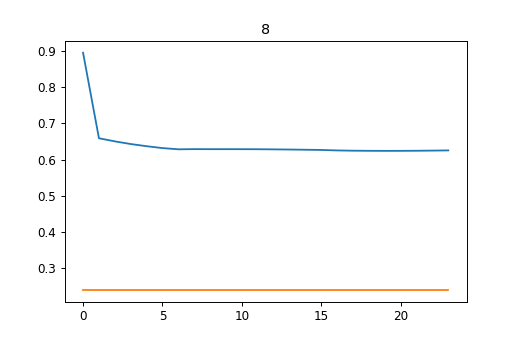

[0.89493406 0.71441275 0.71392852 0.71227622 0.70994842 0.70786178
 0.70574647 0.70433486 0.70276839 0.70132035 0.70005691 0.69892704
 0.69792116 0.69703919 0.69624507 0.69547284 0.69441187 0.69397169
 0.69290102 0.69209009 0.69147652 0.69101632 0.69073725 0.69067919]


<IPython.core.display.Javascript object>


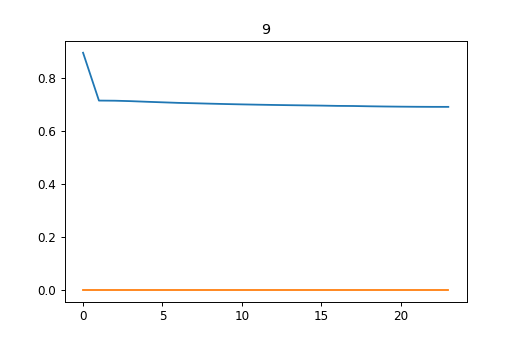

[0.89495623 0.71870989 0.71771741 0.71469045 0.71135187 0.70848554
 0.70734984 0.70876366 0.70961392 0.71012378 0.71055901 0.71075833
 0.71068907 0.71037292 0.70983094 0.70904791 0.70720875 0.7066741
 0.70494127 0.70346069 0.70214653 0.70095187 0.69992775 0.69916517]


<IPython.core.display.Javascript object>


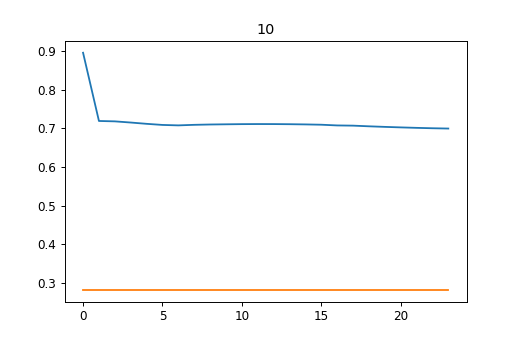

[0.89495534 0.59828675 0.58330876 0.57153392 0.56346762 0.5568583
 0.55206525 0.55171543 0.55039173 0.54905784 0.54758644 0.54614031
 0.54471254 0.54331958 0.54194367 0.54072863 0.5381794  0.53731591
 0.53711569 0.53667939 0.53634888 0.53612572 0.53591013 0.53560883]


<IPython.core.display.Javascript object>


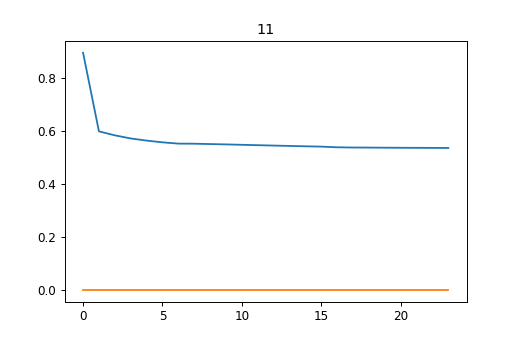

[0.89492285 0.77447617 0.77511734 0.77459037 0.77126563 0.76712716
 0.76183325 0.757882   0.75414038 0.75086224 0.74795812 0.74537885
 0.74308515 0.74103653 0.73907912 0.73697937 0.73532027 0.73387051
 0.73165929 0.72966009 0.72784281 0.72622943 0.72486472 0.7237643 ]


<IPython.core.display.Javascript object>


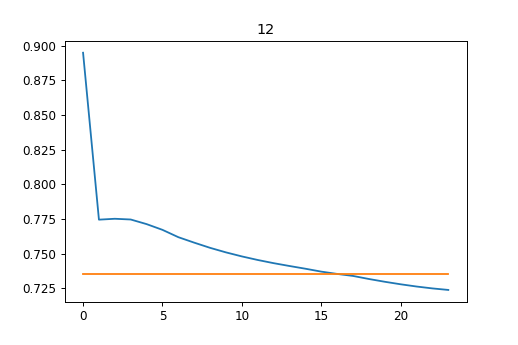

[0.89496654 0.62159687 0.60799414 0.59596217 0.58750224 0.58035094
 0.57565242 0.57656491 0.57660657 0.57660764 0.57649487 0.57624841
 0.57582849 0.57527959 0.57462239 0.57395047 0.57186621 0.57170874
 0.57157153 0.57134914 0.57128161 0.57137346 0.57158053 0.57186466]


<IPython.core.display.Javascript object>


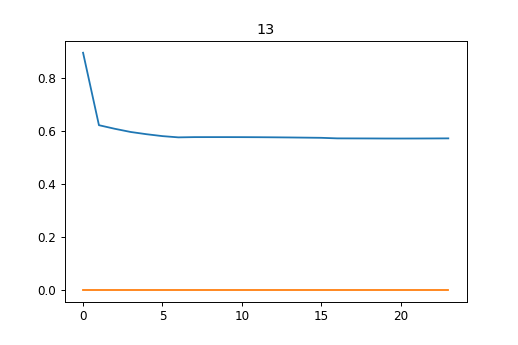

[0.89495897 0.61374652 0.60044396 0.58917141 0.58138955 0.5750193
 0.57061553 0.57079589 0.57008088 0.56931603 0.5684492  0.56756043
 0.56663215 0.56569314 0.56474173 0.56388426 0.56173056 0.56137443
 0.56125367 0.56100643 0.56089526 0.56091535 0.56100094 0.56109548]


<IPython.core.display.Javascript object>


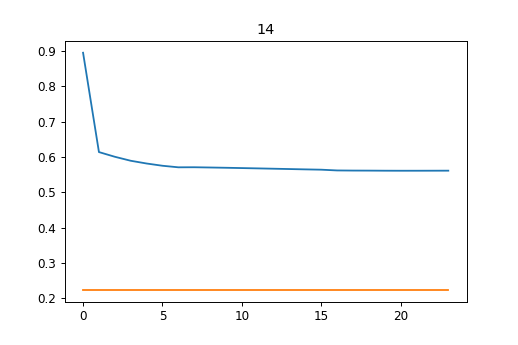

[0.89495713 0.66402572 0.65970248 0.65589809 0.65220052 0.64914858
 0.64627206 0.64456522 0.64262366 0.64094949 0.63945866 0.63815963
 0.63701004 0.63601422 0.63518584 0.63453907 0.63374656 0.63345438
 0.63327342 0.6333226  0.6336512  0.63422    0.63498497 0.63588315]


<IPython.core.display.Javascript object>


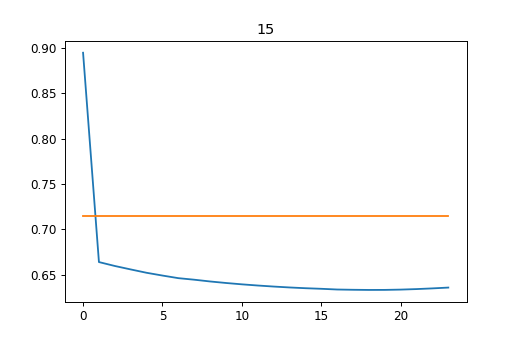

[0.89496517 0.92044491 0.92875946 0.93197358 0.92803597 0.92357582
 0.91629136 0.91439033 0.91023958 0.90728402 0.90529126 0.90372312
 0.90242875 0.90123451 0.90001035 0.89849687 0.89575201 0.89591718
 0.89470059 0.89381617 0.89314234 0.89257503 0.89210391 0.89181554]


<IPython.core.display.Javascript object>


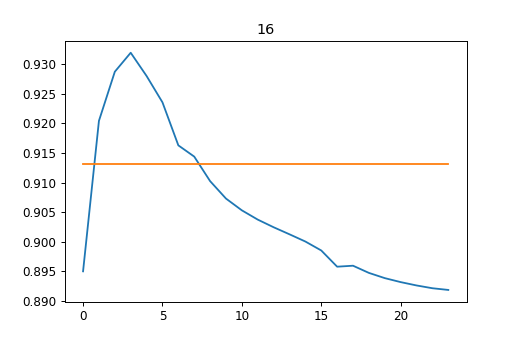

[0.8949514  0.65268809 0.64277494 0.63633394 0.63128334 0.62677544
 0.62347245 0.62330294 0.6223613  0.6216284  0.62081593 0.61989546
 0.61884058 0.61769772 0.61651468 0.61528414 0.61391515 0.61263913
 0.61189127 0.61136222 0.61098272 0.6106714  0.61036396 0.60999894]


<IPython.core.display.Javascript object>


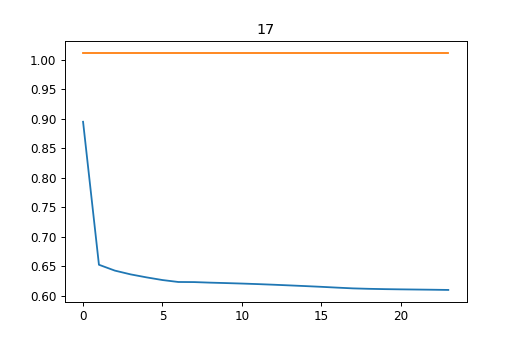

[0.89494556 0.5938741  0.57789171 0.56552541 0.55705369 0.5499776
 0.54485571 0.54447246 0.54302239 0.54155648 0.53991151 0.53826594
 0.53662348 0.53500831 0.53339171 0.53192747 0.52905881 0.52788448
 0.52749723 0.52682042 0.5262273  0.52572554 0.52520669 0.52456552]


<IPython.core.display.Javascript object>


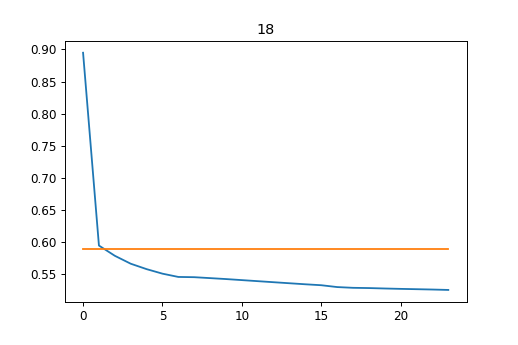

[0.89494878 0.68051761 0.67728621 0.67355537 0.66971797 0.66661668
 0.66340876 0.66096807 0.6584999  0.65628028 0.65428531 0.65250993
 0.65091801 0.64951122 0.648274   0.64719397 0.64589918 0.64518362
 0.6443522  0.6437214  0.64333081 0.64314795 0.64315248 0.64331025]


<IPython.core.display.Javascript object>


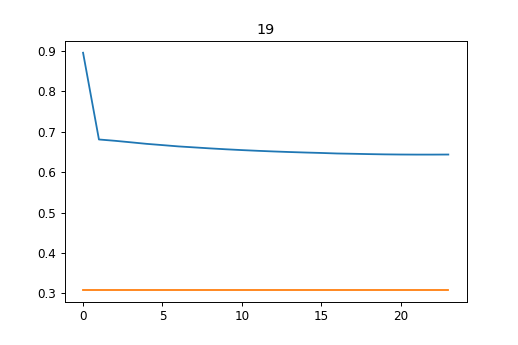

In [96]:
for n,e in enumerate(IncPred):
    print(e)
    plt.figure()
    plt.plot(e)
    plt.plot(Inctargets[n])
    plt.title(str(n))
    plt.show()

In [94]:
first[1]

array([[0.5       , 1.36582629],
       [0.        , 0.        ],
       [0.2       , 0.70842666],
       [0.1       , 0.34478135],
       [0.1       , 0.2977569 ],
       [0.3       , 0.54542187],
       [0.2       , 0.37134075],
       [0.4       , 0.62522314],
       [0.2       , 0.23989053],
       [0.        , 0.        ],
       [0.1       , 0.28235294],
       [0.        , 0.        ],
       [0.3       , 0.73525145],
       [0.        , 0.        ],
       [0.1       , 0.22347756],
       [0.3       , 0.71468739],
       [0.8       , 0.91312655],
       [0.8       , 1.01191944],
       [0.2       , 0.5889141 ],
       [0.2       , 0.30860819]])

# Make New Predictions:

In [81]:
thisweek = 52
thisyear = 2016
with tf.Session() as sess:
    init = tf.initialize_all_variables()
    sess.run(init)
    saver = tf.train.Saver()
    kp=1.0
    saver.restore(sess, "C:/Users/Vivi/Desktop/hack4health_RKI-data-scripts/DieInfluenza/log/FFNCountyRisk.ckpt")
    print("model loaded")
    #b,s,c = getLastWeek(thisweek,thisyear)
    batch_size = s
    _,loss,newoutput= sess.run([train_op,loss_op,outP], feed_dict={X: b[0],Y: b[1],keep_probability:kp}) 
    print(newoutput)


[[-0.23304832  0.89490265]
 [-0.23322938  0.894943  ]
 [-0.23333652  0.894965  ]
 [-0.23309855  0.894922  ]
 [-0.23310164  0.894929  ]
 [-0.23316516  0.8949678 ]
 [-0.23332448  0.894959  ]
 [-0.23336104  0.8949546 ]
 [-0.2332894   0.8949618 ]
 [-0.23319277  0.89493406]
 [-0.2332098   0.89495623]
 [-0.23335464  0.89495534]
 [-0.23309113  0.89492285]
 [-0.23332694  0.89496654]
 [-0.23333243  0.894959  ]
 [-0.23325549  0.8949571 ]
 [-0.23303685  0.8949652 ]
 [-0.23330124  0.8949514 ]
 [-0.23336436  0.89494556]
 [-0.23323429  0.8949488 ]]


In [ ]:
predicted = pd.DataFrame(np.multiply(output,100))
counties = pd.DataFrame(c)

d = predicted.join(counties.reset_index(),lsuffix='x')
#d = d[['countyx','1']]
d.columns = ['count','incidence','ID','county']
d['week']=1#thisweek+1
d['year']=thisyear+1
d = d[['count','incidence','county','week','year']]
d.to_csv('Prediction_1_2017.csv')

In [ ]:
mses = []
for b in getBatches(batch_size,'train'):
    A = [b[0][0][1],b[0][0][2]]
    B = b[1][0]
    mse = ((A-B)**2).mean()
    mses.append(mse)